<a href="https://colab.research.google.com/github/moulikatou/Ter_securite_Alimentaire_Miashs/blob/vmelancon/notebooks/ter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# __Projet TER analyse de données__

# IMPORTS & GLOBAL VARIABLES
----

In [208]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

path = "/content/drive/MyDrive/COLAB_STUFF/donnees/" # "../TER_M1_MIASHS/donnees/"
filename = "reduced_named_data.csv"

La cellule suivante permet de vous connecter a votre google drive, vous pourrez ainsi lire et sauver des fichiers dans ce même drive.

In [209]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


On remarque que beaucoup de valeurs sont à 0, pour pouvoir mieux remarquer la distribution nous allons effectuer le même affichage sans toutes les valeurs à 0.

# CHARGEMENT DES DONNEES
----

In [303]:
col = {
    "metadata" : ["REG", "PROV", "COM", "VIL", "MEN", "YEAR"],
    "data" : ["Q1","Q2","Q3","Q4","Q5"],
    "target" : ["CSI"]
}

In [304]:
raw_data = pd.read_csv(path + filename)
raw_data = raw_data.set_index(raw_data.Index.astype(int)).iloc[:, 2:]
raw_data[col["metadata"][1:]] = raw_data[col["metadata"][1:]].astype(int)
raw_data.head()

,REG,PROV,COM,VIL,MEN,YEAR,Q1,Q2,Q3,Q4,Q5,CSI
Index,,,,,,,,,,,,
0,BOUCLE DU MOUHOUN,13,1,1,45,2017,0.0,0.0,0.0,0.0,0.0,0.0
1,BOUCLE DU MOUHOUN,13,1,1,58,2017,3.0,2.0,4.0,2.0,0.0,17.0
2,BOUCLE DU MOUHOUN,13,1,1,67,2017,0.0,0.0,0.0,0.0,0.0,0.0
3,BOUCLE DU MOUHOUN,13,1,1,75,2017,0.0,0.0,0.0,0.0,0.0,0.0
4,BOUCLE DU MOUHOUN,13,1,1,84,2017,0.0,0.0,0.0,0.0,0.0,0.0


# ANALYSE DESCRIPTIVE
----
Regardons comment nos données sont formés.

## Données nulles et valeurs à 0

In [305]:
plot_data = raw_data
plot_data = plot_data.melt(id_vars=(col["metadata"] + col["target"]), var_name="QUESTION", value_name="ANSWER")

Regardons quelques informations par rapport aux données nulles ainsi qu'au questions ayant une réponse égale à 0.

In [306]:
print(raw_data[col["data"]].isna().sum()) # en voyant le résultats, on peut se permettre de se débarasser des valeurs manquantes
raw_data = raw_data.dropna()

Q1    145
Q2    269
Q3    272
Q4    282
Q5    292
dtype: int64


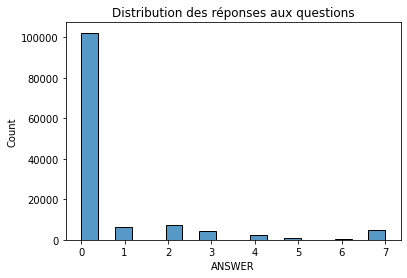

In [307]:
sns.histplot(plot_data.ANSWER)
plt.title("Distribution des réponses aux questions")
plt.show()

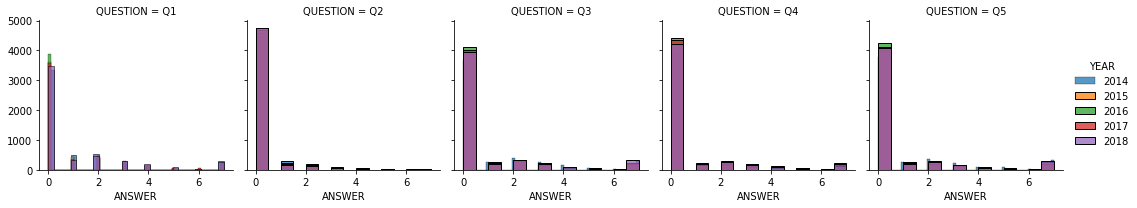

In [308]:
g = sns.FacetGrid(plot_data, col="QUESTION", hue="YEAR")
g.map(sns.histplot, "ANSWER")
g.add_legend()
plt.show()

Au vue du nombre de réponses à 0, nous allons les retirer du jeu de données pour pouvoir mieux visualiser les informations sur l'évolution du CSI au cours de ces dernières années.

In [309]:
plot_data = plot_data[plot_data.CSI != 0.0]

## Analyse du CSI

Nous allons maintenant regarder la corrélation entre chaque questions. Ainsi que l'évolution du CSI durant ces dernières années, avec un découpage par région.

In [310]:
corr = raw_data[raw_data.CSI != 0.0][col["data"]].corr()
corr

,Q1,Q2,Q3,Q4,Q5
Q1,1.000000,0.101657,0.254113,0.224286,0.244294
Q2,0.101657,1.000000,0.161605,0.200126,0.179281
Q3,0.254113,0.161605,1.000000,0.507498,0.528698
Q4,0.224286,0.200126,0.507498,1.000000,0.474593
Q5,0.244294,0.179281,0.528698,0.474593,1.000000


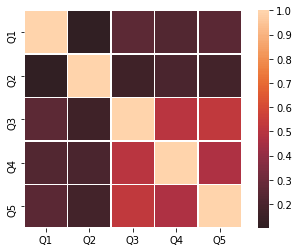

In [311]:
sns.heatmap(corr, vmax=1., center=0, square=True, linewidths=.5, cbar_kws={"shrink": 1})
plt.show()

On peut remarquer que les questions 3, 4 et 5 semble être plus corrélées entre elles que les autres questions. Ce qui se traduit par le fait que ces questions représentes plus ou moins la même variance du CSI.

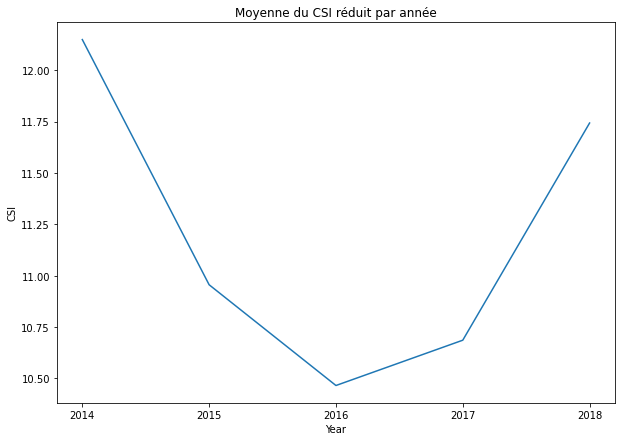

In [359]:
years, by_year = [], []
for year in plot_data.YEAR.unique():
    d = plot_data[plot_data.YEAR == year]
    by_year.append(d.CSI.mean())
    years.append(year)

plt.figure(figsize=(10,7))
sns.lineplot(x=years, y=by_year)
plt.title("Moyenne du CSI réduit par année")
plt.xlabel("Year")
plt.ylabel("CSI")
plt.xticks(np.arange(2014, 2019, step=1))
plt.show()

On remarque que le CSI à grandement diminué de 2014 jusqu'en 2016 puis est remonté jusqu'a 2018.

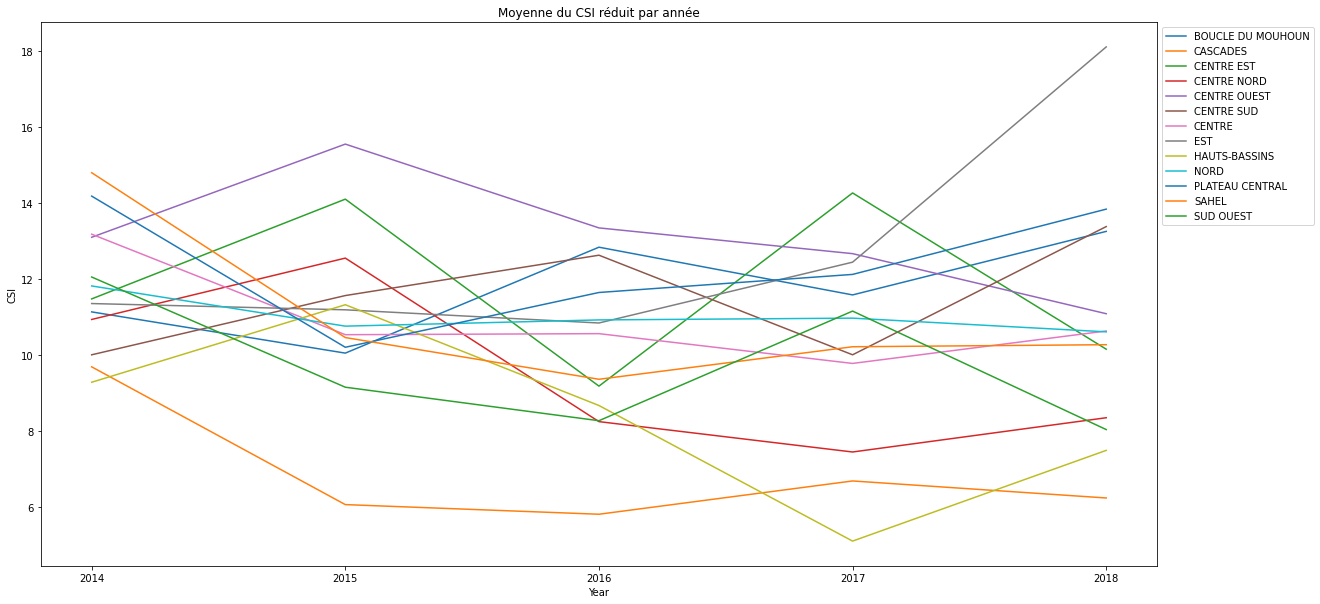

In [358]:
plt.figure(figsize=(20,10))

for reg in plot_data.REG.unique():
    years, by_year = [], []
    df = plot_data[plot_data.REG == reg]
    for year in df.YEAR.unique():
        d = df[df.YEAR == year]
        years.append(year)
        by_year.append(d.CSI.mean())

    sns.lineplot(x=years, y=by_year)

plt.legend(bbox_to_anchor=(1,1), labels=plot_data.REG.unique())
plt.title("Moyenne du CSI réduit par année")
plt.xlabel("Year")
plt.ylabel("CSI")
plt.xticks(np.arange(2014, 2019, step=1))
plt.show()

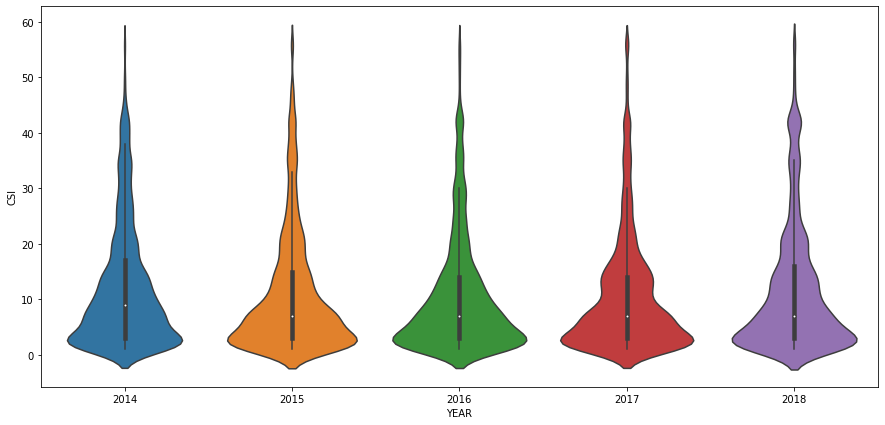

In [365]:
plt.figure(figsize=(15,7))
sns.violinplot(x="YEAR", y="CSI", data=plot_data)
plt.show()